Code creating an a-priori plot of DOPs for a survey area

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import sqrt, diag, pi, sin, cos, arctan2
from numpy.linalg import inv, det, pinv, eig
from scipy.stats.distributions import chi2

# Let's make this somewhat realitic - create a rectangular survey area of 10x10km as defined in 
# Cartesian isotropic Eastings and Northings. 

# The survey will contain n known locations x_i (i=[0,n>)
# We can make n observations!

In [4]:
def get_geometry(geometry='triangular'):
    if geometry.lower() == 'linear':
        xb = np.array([[2, 5, 4], [1, 4, 3]])
    elif geometry.lower() == 'triangular':
        xb = np.array([[0, 2, 4], [0, 3, 1]])
    else:
        raise Runtimeerror(
            'Invalid geometry option %s must be \'linear\' or \'triangular\')' % geometry.lower())
    return xb

# Observation quality is usually specified as fixed quantity (sd_l_fix; instrument noise) + a range
# dependent quantity (sd_l_obs; msmt noise)


def get_obs_quality(obs_qual='good'):
    if obs_qual.lower() == 'bad':
        sd_l_fix = .1
        sd_l_obs = .05
    elif obs_qual.lower() == 'good':
        sd_l_fix = .01
        sd_l_obs = .005
    else:
        raise Runtimeerror(
            'Invalid obs_qual option %s must be \'bad\' or \'good\')' % obs_qual.lower())
    return sd_l_fix, sd_l_obs


def get_estimate_x(estimate_x='good'):
    if estimate_x.lower() == 'bad':
        x_e = np.array([[2.5], [.5]])
    elif estimate_x.lower() == 'really bad':
        x_e = np.array([[2.5], [1.5]])
    elif estimate_x.lower() == 'soso':
        x_e = np.array([[2.3], [1.5]])
    elif estimate_x.lower() == 'good':
        x_e = np.array([[1.9], [1.9]])
    else:
        raise Runtimeerror(
            'Invalid estimate_x option %s must be \'bad\' or \'good\')' % estimate_x.lower())
    return x_e

def rot_az(a):
    return np.array([[cos(a),sin(a)],[-sin(a),cos(a)]])

# Reflection in the 1-axis
P1 = np.array([[1,0],[0,-1]])

# def rot_az(a):
#     return np.array([[sin(a),cos(a)],[-cos(a),sin(a)]])

In [5]:
# In this case we are not trying to solve an unknown, but rather trying to predict what the uncertainty is
# for any location i.e. the estimands x are known! Since we will create a grid of known locations we will 
# refer to it as X 

steps = 10
x_range = (3000,4000)
y_range = (7000,8000)
X0,X1 = np.meshgrid(np.linspace(x_range[0],x_range[1],steps),np.linspace(y_range[0],y_range[1],steps))

# Vector for scaling LOP representations of
bl = np.array([[0,0],[-(x_range[1]-x_range[0])/steps/3,(x_range[1]-x_range[0])/steps/3]])
l_bl = bl[1,1]-bl[1,0]

# Number of components of polygon approaching circle
n_c = 1500
t = np.linspace(0,2*pi,n_c)
circle = np.array([sin(t),cos(t)]) # Angles re. North i.e., azimuths

# 'linear' and 'triangular' geometries
geometry_types = {}
geometry_types['triangular']=np.array([[3150., 3550., 3950.],[7150., 7950., 7150.]])
geometry_types['linear']=np.array([[3250., 3550., 3950.],[7050., 7350., 7750.]])

rows,cols = X1.shape 

observable_types = {}
observable_types['ranges'] = (0)
observable_types['azimuths'] = (1)
observable_types['hyperbolae'] = (2)
observable_types['angles'] = (3)


/tmp/ipykernel_1743470/2048350504.py:172: RuntimeWarning: invalid value encountered in true_divide
  lop = np.array([x_lop,b_sd*sqrt((x_lop/a)**2-1)])
/tmp/ipykernel_1743470/2048350504.py:172: RuntimeWarning: invalid value encountered in true_divide
  lop = np.array([x_lop,b_sd*sqrt((x_lop/a)**2-1)])
/tmp/ipykernel_1743470/2048350504.py:172: RuntimeWarning: invalid value encountered in true_divide
  lop = np.array([x_lop,b_sd*sqrt((x_lop/a)**2-1)])
/tmp/ipykernel_1743470/2048350504.py:172: RuntimeWarning: invalid value encountered in true_divide
  lop = np.array([x_lop,b_sd*sqrt((x_lop/a)**2-1)])
/tmp/ipykernel_1743470/2048350504.py:172: RuntimeWarning: invalid value encountered in true_divide
  lop = np.array([x_lop,b_sd*sqrt((x_lop/a)**2-1)])
/tmp/ipykernel_1743470/2048350504.py:172: RuntimeWarning: invalid value encountered in true_divide
  lop = np.array([x_lop,b_sd*sqrt((x_lop/a)**2-1)])
/tmp/ipykernel_1743470/2048350504.py:172: RuntimeWarning: invalid value encountered in true_di

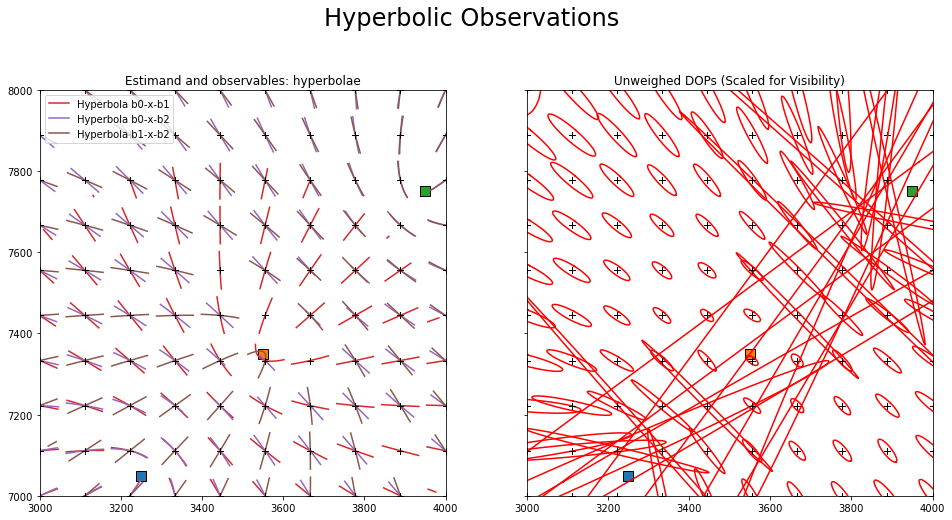

In [33]:
# Select the type of observable
# observable_type = observable_types['ranges']
# observable_type = observable_types['azimuths']
observable_type = observable_types['hyperbolae']
# observable_type = observable_types['angles']

# select the geometry
x_b_b = geometry_types['linear']
# x_b_b = geometry_types['triangular']

# Desired confidence interval
ci = .95

# Set the scaling for visualizing the LOPs
if observable_type == observable_types['ranges']:
    str_title = 'Range Observations'
    dop_scale = (bl[1, 1]/2)
elif observable_type == observable_types['azimuths']:
    str_title = 'Azimuth Observations'
    dop_scale = 1/(bl[1, 1]/2)*7/steps
elif observable_type == observable_types['hyperbolae']:
    str_title = 'Hyperbolic Observations'
    dop_scale = (bl[1, 1]/2)/2
elif observable_type == observable_types['angles']:
    str_title = 'Angle Observations'
    dop_scale = 1/(bl[1, 1]/2)*3/steps


# Determine the number of observations
u, n = x_b_b.shape

# Therefore the lops bases
br = np.zeros((2, n))

# Base identifier (for hyperbolic and angle LOPs)
b = np.array([[0],[1]])

# Allocate memory for angle lop parameters
g = np.zeros(2)
s = np.zeros((2,1))

# Allocate memory for the ranges to all estimands = This will be an rows x cols x u array
lm = np.zeros((n, rows, cols))
# Allocate memory for the azimuths to all estimands = This will be an rows x cols x u array
az = np.zeros((n, rows, cols))

# Calculate the azimuths, ranges to all estimands x
for i in range(n):
    lm[i] = sqrt((x_b_b[0, i]-X0)**2+(x_b_b[1, i]-X1)**2)
    az[i] = arctan2((x_b_b[0, i]-X0), (x_b_b[1, i]-X1))

# The value of the quadratic form associated to the confidence interval
k_2 = chi2.ppf(ci, df=u)

fig, ((ax0, ax1)) = plt.subplots(figsize=(16, 8),
                                 nrows=1, ncols=2, sharey=True, sharex=True)
plt.suptitle(str_title, fontsize=24, y=1)

# Allocate memory for design matrix A and rotation matrix Q
A = np.zeros((n, u))
Q = np.eye(u)


# The current location x
x = np.zeros((2,1))

# Brute force, as it leads to easier to understand, but slow code

for i in range(n):
    # Plot the bases
    ax0.plot(x_b_b[0, i], x_b_b[1, i], 's', markeredgecolor='k',
             markerfacecolor='C'+str(i), markersize=10)
    ax1.plot(x_b_b[0, i], x_b_b[1, i], 's', markeredgecolor='k',
             markerfacecolor='C'+str(i), markersize=10)


for i in range(steps):
    for j in range(steps):

        # Plot the estimand locations
        ax0.plot(X0[i], X1[j], 'k+')
        ax1.plot(X0[i], X1[j], 'k+')
        
        x[0,0] = X0[i,j]
        x[1,0] = X1[i,j]

        # Plot the LOPs and DOPs
        # This is really inefficient, but relatively easy to understand
        

        for k in range(n):
            if observable_type == observable_types['azimuths']:

                # Plot all LOPs at the current estimand
                br = rot_az(az[k, i, j])@bl
                
                label = 'Azimuth to b'+str(k)
                if i == j == 0:
                    ax0.plot(br[0]+X0[i, j], br[1]+X1[i, j], color='C'+str(k), markersize=10, label = label)
                else:
                    ax0.plot(br[0]+X0[i, j], br[1]+X1[i, j], color='C'+str(k), markersize=10)

                # Establish the design at the current estimand
                # Could be solved simultaneously for all lm, for clarity done on obs by obs basis
                A[k, 0] = (X1[i, j]-x_b_b[1, k])/(lm[k, i, j]**2)
                A[k, 1] = -(X0[i, j]-x_b_b[0, k])/(lm[k, i, j]**2)

            elif observable_type == observable_types['ranges']:
                # Plot all LOPs at the current estimand
                # Make use of arc length = angle * radius to determine what part of the lop to plot
                # Plot using parametric representation of a circle
                az_t = (az[k, i, j]+pi) % (2*pi)
                t_start = np.abs(t-(az_t-bl[1, 1]/lm[k, i, j])).argmin()
                t_end = np.abs(t-(az_t+bl[1, 1]/lm[k, i, j])).argmin()

                # Get the locus of points to plot for each plot and plot them
                lop = lm[k, i, j]*circle[:, t_start:t_end+1]

                label = 'Range to b'+str(k)
                if i == j == 0:
                    ax0.plot(lop[0]+x_b_b[0, k], lop[1] +
                         x_b_b[1, k], color='C'+str(k), markersize=10, label = label)
                else:
                    ax0.plot(lop[0]+x_b_b[0, k], lop[1] +
                         x_b_b[1, k], color='C'+str(k), markersize=10)

                # Establish the design at the current estimand
                # Could be solved simultaneously for all lm, for clarity done on obs by obs basis
                A[k, 0] = (X0[i, j]-x_b_b[0, k])/lm[k, i, j]
                A[k, 1] = (X1[i, j]-x_b_b[1, k])/lm[k, i, j]

            elif observable_type == observable_types['hyperbolae']:
                # This is painfully slow - not optimized at all in order to keep
                # the code more legible
                # This could be orders of magniture more efficient
                
                # Note that there are n factorial potential combinations of stations, we will only consider
                # n possible lops
                if k < n-1:
                    b[0] = 0
                    b[1] = k + 1
                else:
                    b[0] = 1
                    b[1] = 2

                # Calculate the length of baseline connecting the base stations b0, b1
                lb = sqrt((x_b_b[:,b[0]]-x_b_b[:, b[1]]).T@(x_b_b[:,b[0]]-x_b_b[:, b[1]]))

                # Determine the azimuth of the base line b0, b1
                azb = arctan2((x_b_b[0, b[1]]-x_b_b[0, b[0]]),(x_b_b[1, b[1]]-x_b_b[1, b[0]]))[0]
                
                # Populate rotation matrix Q based on the azimuth
                Q = rot_az(azb-pi/2)
                
                # Construct the hyberbolae on zero (h = k = 0)
                # Half distance difference
                a = ((lm[b[0], i, j]-lm[b[1], i, j])/2)[0]
                
                # Half baseline 
                c = lb/2
                
                # Connecting semi-distance
                b_sd=sqrt(c**2-a**2)[0][0]
                
                # Now construct the hyperbola
                # y=b(m)*sqrt((a(m)/x)**2+1), make sure to be on the correct branch
                num_x = 400
                x_lop = np.linspace(a,3*a,num_x)
                    
                # The locus of points forming the hyperbolae
                # y = b*sqrt((x/a)**2 - 1)
                lop = np.array([x_lop,b_sd*sqrt((x_lop/a)**2-1)])
                                
                # Extend the hyperbola beyond the 1-axis, also reverse the
                # order of the points in the first branch to avoid a straight
                # line to the 1-axis intersection
                lop = np.hstack((np.fliplr(lop),P1@lop))
                
                # Rotate the LOP to the azimuth-pi/2 of the baseline
                lop = Q@lop
                
                # Translate the lop to the middle of the baseline
                lop_orig = x_b_b[:, b[0]] + (x_b_b[:, b[1]]-x_b_b[:, b[0]])/2 
                lop += np.array([lop_orig[0],lop_orig[1]])
                
                loc = np.array([[X0[i,j]],[X1[i,j]]])
                
                # Find the bit of the lop close to the current estimand
                # The distance
                d_2 = np.diag((lop - loc).T@(lop - loc))
                ib = d_2 < (.7*l_bl)**2
                
                min_d_2 = np.min(d_2)
                try:
                    i_min = np.where(min_d_2 == d_2)[0][0]
                except:
                    break
                    
                # Note that this may pick up values on the wrong side of the 1-axis of the
                # hyperbola as well - avoid this
                in_range = True
                for q in range(i_min,num_x):
                    if ib[q] == False:
                        in_range = False
                    ib[q] = in_range
                in_range = True
                for q in range(i_min,0,-1):
                    if ib[q] == False:
                        in_range = False
                    ib[q] = in_range             
             
                # Plot the lop branch close to the current estimand
                label = 'Hyperbola b'+str(b[0][0])+'-x-'+'b'+str(b[1][0])
                if i == j == 0:
                    ax0.plot(lop[0,ib], lop[1,ib], color='C'+str(k+n), markersize=10, label = label)
                else:
                    ax0.plot(lop[0,ib], lop[1,ib], color='C'+str(k+n), markersize=10)
                
                # Establish the design at the current estimand
                # Could be solved simultaneously for all lm, for clarity done on obs by obs basis
                A[k, 0] = (X0[i, j]-x_b_b[0, b[0]])/lm[b[0], i, j] - (X0[i, j]-x_b_b[0, b[1]])/lm[b[1], i, j]
                A[k, 1] = (X1[i, j]-x_b_b[1, b[0]])/lm[b[0], i, j] - (X1[i, j]-x_b_b[1, b[1]])/lm[b[1], i, j]

        
            if observable_type == observable_types['angles']:
                
                # Note that there are n factorial potential combinations of stations, we will only consider
                # n possible lops
                if k < n-1:
                    b[0] = 0
                    b[1] = k + 1
                else:
                    b[0] = 1
                    b[1] = 2
                
                # Brute force approach - no optimization whatsoever
                # Use Thales' algorithm to find the center and diameter of the circle
                # Through the location of the estimand and the observed bases
                #
                # Thales theorem: The diameter of a circle always
                # subtends a right angle to any point on the circle
                #
                # In our case point x and two bases b1 and b2 are located along a circle
                #
                # If we create line through x and the center of the circle then that line 
                # intersects the circle at x and some point s. According to Thales the line x-s
                # then subtends a right angle to base b1, and also a right angle to base b2.
                #
                # we know the coordinates of x and the base stations, thus we can construct the
                # line segments x-b1 and x-b2. The lines orthogonal to these line segments at b1 and b2 
                # respectively then must intersect the circle at s.
                #
                # Since we know the direction (gradient) of these lines (orthogonal to x-b1 and x-b2 
                # respectively) and one point on them (b1 and b2 respectively) we can construct them
                # and at their intersection find the location s. 
                #
                # This allows the construction of the line segment x-s, whose halfway point is the 
                # center of the circle, and whose half length is the radius.
                
                # Determine the gradients of the lines orthogonal to the lines connecting x to the bases
                g = -(x_b_b[0,b]-X0[i,j])/(x_b_b[1,b]-X1[i,j])
                
                # Determine the coordinates of the intersection s
                s[0]=(x_b_b[1,b[1]]-x_b_b[1,b[0]]+g[0]*x_b_b[0,b[0]]-g[1]*x_b_b[0,b[1]])/(g[0]-g[1])
                s[1]=x_b_b[1,b[0]]+g[0]*(s[0]-x_b_b[0,b[0]])
                
                # The center of the circle
                xc = x + (s-x)/2
                
                # The radius of the circle
                r = sqrt((s-x).T@(s-x))/2
                
                # The azimuth of the radius (mod 2pi)
                az_t = arctan2(X0[i,j] - xc[0], X1[i,j] - xc[1]) % (2*pi)
                
                # the indexes of the circle        
                t_start = np.abs(t-(az_t-bl[1, 1]/r)).argmin()
                t_end = np.abs(t-(az_t+bl[1, 1]/r)).argmin()
                
                # The LOP to be plotted
                lop = r * circle[:,t_start:t_end] + xc
                
                # Plot it     
                label = 'Angle b'+str(b[0][0])+'-x-'+'b'+str(b[1][0])
                if i == j == 0:
                    ax0.plot(lop[0], lop[1], color='C'+str(k+n), markersize=10, label = label)
                else:
                    ax0.plot(lop[0], lop[1], color='C'+str(k+n), markersize=10)

                # Establish the design at the current estimand
                # Could be solved simultaneously for all lm, for clarity done on obs by obs basis
                A[k, 0] = (X1[i, j]-x_b_b[1, b[0]])/(lm[b[0], i, j]**2)-(X1[i, j]-x_b_b[1, b[1]])/(lm[b[1], i, j]**2)
                A[k, 1] = -(X0[i, j]-x_b_b[0, b[0]])/(lm[b[0], i, j]**2)+(X0[i, j]-x_b_b[0, b[1]])/(lm[b[1], i, j]**2)
        
        # Plot the estimand x locations 
        ax0.plot(X0[i], X1[j], 'k+')
        ax1.plot(X0[i], X1[j], 'k+')
        


        # Get the unitless design covariance of the estimand (we have not multiplied by a scalar)
        # We will refer to this as the DOP
        # Use the pseudo inverse to avoid issues with singularities
        Cx = pinv(A.T@A)

        # Get the Eigenvectors and values
        d, V = eig(Cx)

        # Create the locus describing the ci uncertainty region
        locus = dop_scale * \
            V@np.stack((sqrt(d[0]*k_2)*circle[0], 
                        sqrt(d[1]*k_2)*circle[1]))+[[X0[i, j]], [X1[i, j]]]
        


        # Plot the uncertainty region
        ax1.plot(locus[0, :], locus[1, :], 'r')

ax0.set_title('Estimand and observables: ' +
              [k for k, v in observable_types.items() if v == observable_type][0])
ax0.set_xlim(X0[0, 0], X0[0, -1])
ax0.set_ylim(X1[0, 0], X1[-1, 0])
ax0.set_aspect('equal')
ax0.legend()
ax1.set_title('Unweighed DOPs (Scaled for Visibility)')
ax1.set_xlim(X0[0, 0], X0[0, -1])
ax1.set_ylim(X1[0, 0], X1[-1, 0])
ax1.set_aspect('equal')

plt.show()

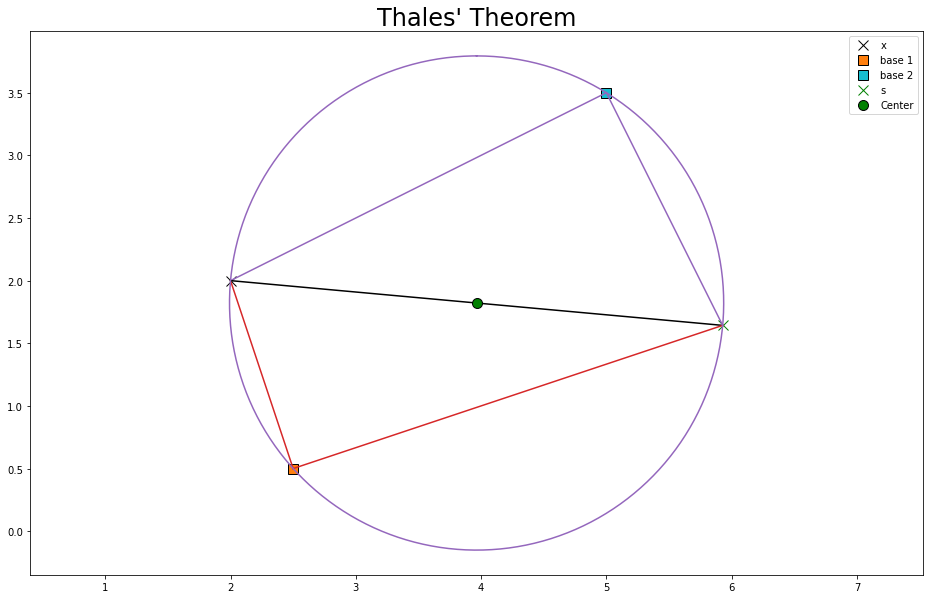

In [45]:
# Illustration of Thales' theorem
fig = plt.figure(figsize=(16, 10))
plt.title('Thales\' Theorem', fontsize=24, y=1)
s = np.zeros((2,1))

x_b_b = np.array([[1.5,5.5,9.5],[1.5,9.5,1.5]])
x_b_b = np.array([[2.5,5,9.5],[0.5,3.5,7.5]])
u,n = x_b_b.shape
# x_b_b = np.array([[1.5,5.5,9.5,1.5],[1.5,9.5,1.5,1.5]])


# The location of interest
x = np.array([[2],[2]])

# Plot the bases and estimand x
plt.plot(x[0],x[1], 'x', markeredgecolor='k',
             markerfacecolor='C'+str(i), markersize=10, label = 'x')
plt.plot(x_b_b[0,0],x_b_b[1,0], 's', markeredgecolor='k',
             markerfacecolor='C1', markersize=10, label = 'base 1')
plt.plot(x_b_b[0,1],x_b_b[1,1], 's', markeredgecolor='k',
             markerfacecolor='C'+str(i), markersize=10, label = 'base 2')

# Draw a line through x and x_b_b[0]
plt.plot([x[0,0],x_b_b[0,0]],[x[1,0],x_b_b[1,0]], '-', color = 'C3')
# Draw a line through x and x_b_b[1]
plt.plot([x[0,0],x_b_b[0,1]],[x[1,0],x_b_b[1,1]], '-', color = 'C4')

# Determine the gradients of the lines orthogonal to the connecting lines
g = -(x_b_b[0]-x[0])/(x_b_b[1]-x[1])

s[0]=(x_b_b[1,1]-x_b_b[1,0]+g[0]*x_b_b[0,0]-g[1]*x_b_b[0,1])/(g[0]-g[1])
s[1]=x_b_b[1,0]+g[0]*(s[0]-x_b_b[0,0])

# Plot s
plt.plot(s[0],s[1], 'x', markeredgecolor='g',
             markerfacecolor='C'+str(i), markersize=10, label = 's')

# Draw a line through x and s
plt.plot([x[0],s[0]],[x[1],s[1]], '-', color = 'k')
# Draw a line through and x_b_b[0] and s
plt.plot([x_b_b[0,0],s[0,0]],[x_b_b[1,0],s[1,0]], '-', color = 'C3')
# Draw a line through and x_b_b[1] and s
plt.plot([x_b_b[0,1],s[0,0]],[x_b_b[1,1],s[1,0]], '-', color = 'C4')

# Center 
xc = x+(s-x)/2
# Radius
r = sqrt((s-x).T@(s-x))/2

# Plot the center location
lop = r*circle + xc

plt.plot(lop[0],lop[1])
plt.plot(xc[0],xc[1], '.', markeredgecolor='k', markerfacecolor='g', markersize=20, label = 'Center')
                    
plt.axis('equal')
plt.legend()
plt.show()

# print(g)